In [1]:
# Standard library imports
import os
import time

# Third-party imports
import imageio
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
import torch
import torch.nn as nn
from IPython import display
from IPython.display import clear_output
from scipy.io import loadmat
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Local application/library specific imports
from kan import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# cpu = torch.device('cpu')
# device = cpu
torch.set_default_dtype(torch.float32)

cuda


## load training sets

parameters shape: (13500, 3)
SQ shape: (13500, 95)
parameters mean: [ 0.21  0.26 10.5 ]
parameters std: [0.11683321 0.14422205 5.7662813 ]
phi in [0.015 0.03  0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15  0.165 0.18
 0.195 0.21  0.225 0.24  0.255 0.27  0.285 0.3   0.315 0.33  0.345 0.36
 0.375 0.39  0.405]
kappa in [0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5 ]
A in [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
Q shape: (95,)
Outliers are at indices: (array([], dtype=int64), array([], dtype=int64))


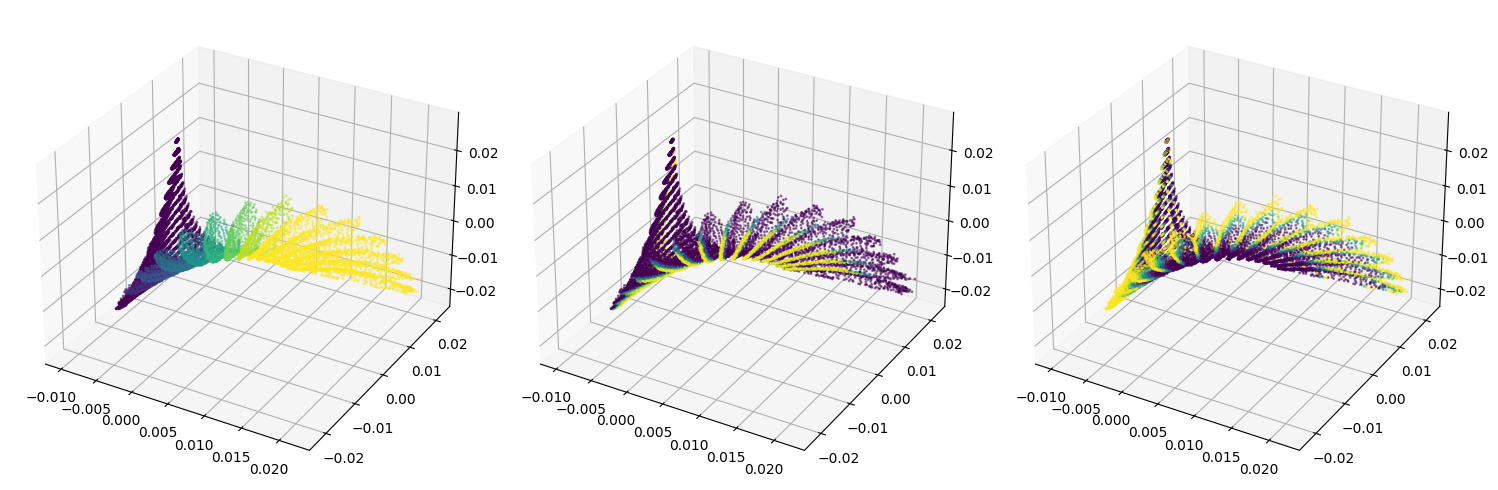

In [2]:
data_rand = loadmat("./training_sets/fg/SQ_rand_fg.mat")
data_grid = loadmat("./training_sets/fg/SQ_grid_fg.mat")
parameters_list = data_grid["parameters_list"]
SQ_list = data_grid["SQ_list"][:,5:]

# SQ_list = np.loadtxt('./training_sets/input_grid_all_GPR80.csv',  delimiter=',')[:,:-1]
# parameters_list = np.loadtxt('./training_sets/target_grid_all.csv',  delimiter=',')[:,:-1]

# exclude highest interaction
index_parameters = (parameters_list[:,2]<=20)*(parameters_list[:,0]<=0.405)
parameters_list = parameters_list[index_parameters,:]
SQ_list = SQ_list[index_parameters,:]

print(f"parameters shape: {parameters_list.shape}")
print(f"SQ shape: {SQ_list.shape}")

# rescale the training set SQ to range [0,1]
exp_scale = 6
def f_inp(sq):
    return np.log(sq)/exp_scale/2 + 0.5

# transform the decoder output to SQ
def f_out(sq_pred):
    return np.exp((sq_pred*2-1)*exp_scale) # inverse of f_inp

parameters_mean = np.mean(parameters_list, axis=0)
parameters_std = np.std(parameters_list, axis=0)
print(f"parameters mean: {parameters_mean}")
print(f"parameters std: {parameters_std}")

set_phi = np.sort(np.array([*set(parameters_list[:,0])]))
set_kappa = np.sort(np.array([*set(parameters_list[:,1])]))
set_A = np.sort(np.array([*set(parameters_list[:,2])]))
print(f"phi in {set_phi}")
print(f"kappa in {set_kappa}")
print(f"A in {set_A}")

# y_train = f_inp(SQ_list)
y_train = SQ_list
x_train = np.array([(parameters_list[:,i]-np.mean(parameters_list[:,i]))/np.std(parameters_list[:,i]) for i in range(3)]).T

def f_params_z(parameters):
    return np.array([(parameters[i]-parameters_mean[i])/parameters_std[i] for i in range(3)])

Q = np.linspace(1.2,20,95)
print(f"Q shape: {Q.shape}")

# Identify outliers
from scipy import stats

# Perform SVD
y_train_centered = y_train - np.mean(y_train, axis=0)
U, S, Vt = np.linalg.svd(y_train_centered, full_matrices=False)

# Get the first 3 principal components
PC = U[:, :3]

# Compute the Z-scores of the principal components
z_scores = np.abs(stats.zscore(PC))

outliers = np.where(z_scores > 4)  # change 3 to a different value if you want to use a different threshold

# Print the indices of the outliers
print("Outliers are at indices:", outliers)

# Remove outliers
y_train = np.delete(y_train, outliers, axis=0)
x_train = np.delete(x_train, outliers, axis=0)

# Perform SVD
y_train_centered = y_train - np.mean(y_train, axis=0)
U, S, Vt = np.linalg.svd(y_train_centered, full_matrices=False)

# Get the first 3 principal components
PC = U[:, :3]

# Create a 3D plot
fig = plt.figure(figsize=(15, 5))
colormap = plt.cm.get_cmap('viridis')  # or any other colormap you like

for i in range(3):
    # Create a colormap based on x_train
    colors = colormap(x_train[:,i])

    ax = fig.add_subplot(1,3,i+1, projection='3d')
    ax.scatter(PC[:, 0], PC[:, 1], PC[:, 2], c=colors, s=1, alpha=0.5)

plt.tight_layout()
plt.show()

## load pretrained KAN model

In [3]:
def calculate_output_size(input_size, filter_size, padding, stride):
    return int((input_size - filter_size + 2*padding) / stride + 1)

def to_torch(array):
    return torch.from_numpy(array).float()

cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')
def to_torch_device(array,device=device):
    return torch.from_numpy(array.astype('float32')).float().to(device)

## define KAN model
Q = np.linspace(1.2,20,95)
class SQ_KAN(nn.Module):
    def __init__(self, width=[4,11,1], width_aug=[3,7,7,3], grid=9, k=3, seed=42, device=device):
        super(SQ_KAN, self).__init__()
        self.kan_aug = KAN(width=width_aug, grid=5, k=k, seed=seed, device=device, noise_scale=2)#, base_fun = 'identity')
        self.kan = KAN(width=width, grid=grid, k=k, seed=seed, device=device, noise_scale=2)#, base_fun = 'identity')
        self.Q_torch = to_torch_device(Q/5)
        
    def forward(self, x):
        x = self.kan_aug(x)
        x_expanded = x.unsqueeze(1).expand(-1, self.Q_torch.size(0), -1)
        Q_expanded = self.Q_torch.unsqueeze(0).unsqueeze(-1).expand(x.size(0), -1, x.size(-1))
        Q_params = torch.cat([Q_expanded, x_expanded], dim=-1)
        Q_params_reshaped = Q_params.view(-1, Q_params.size(-1))
        sq_full = self.kan(Q_params_reshaped)
        sq_full_reshaped = sq_full.view(x.size(0), self.Q_torch.size(0))
        return torch.exp(sq_full_reshaped*2)
    
model_KAN = SQ_KAN(width=[4,11,1], width_aug=[3,7,7,3], grid=5, k=3, seed=11451419, device=device)

## load pretrained network
model_KAN.load_state_dict(torch.load('./saved_model/KAN/model_77_11_grid.pth'))

## define structure factor take continuous Q inputs
class SQ_Q(nn.Module):
    def __init__(self, model_KAN=model_KAN):
        super(SQ_Q, self).__init__()
        self.kan_aug = model_KAN.kan_aug
        self.kan= model_KAN.kan_aug
        
    def forward(self, x):
        x = np.array([(x[i]-np.mean(parameters_list[:,i]))/np.std(parameters_list[:,i]) for i in range(3)]).T
        x = to_torch_device(x)
        x = x.view(-1,3)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


In [4]:
# indexing
def id_params(parameters):
    tol = 1e-6
    id_eta = np.abs(parameters_list[:,0]-parameters[0])<tol
    id_kappa = np.abs(parameters_list[:,1]-parameters[1])<tol
    id_A = np.abs(parameters_list[:,2]-parameters[2])<tol
    return np.where(id_eta*id_kappa*id_A)[0]

list_eta = (np.arange(9))*0.015*3+0.015
list_kappa = (np.arange(8))*0.02*3+0.02*4
list_A = (np.arange(9))*1*2+1

parameters_grid = np.array([x.flatten() for x in np.meshgrid(list_eta,list_kappa,list_A)]).T
index_grid = []
for p in parameters_grid:
    index_grid.append(id_params(p)[0])
sq_GT_grid = SQ_list[index_grid,:]

# speed test
from tqdm import tqdm
sq_KAN_grid = []
for x in tqdm(parameters_grid):
    x = np.array([(x[i]-np.mean(parameters_list[:,i]))/np.std(parameters_list[:,i]) for i in range(3)]).T
    x = to_torch_device(x)
    x = x.view(-1,3)
    sq_KAN = model_KAN(x)[0]
    sq_KAN_grid.append(sq_KAN.detach().cpu().numpy())
sq_KAN_grid = np.array(sq_KAN_grid)    

  0%|          | 0/648 [00:00<?, ?it/s]/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered in

In [5]:
def err_L2(x,y):
    return np.mean((x-y)**2)

err_grid = np.array([err_L2(sq_GT_grid[i],sq_KAN_grid[i]) for i in range(len(index_grid))])

In [6]:
np.mean(err_grid)

0.0024624781741618335

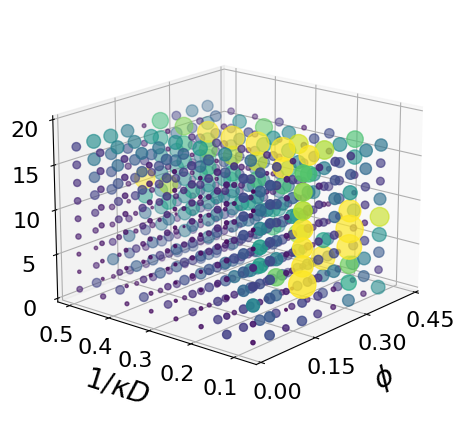

In [7]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(projection='3d')
# ax.view_init(elev=30, azim=64)
ax.view_init(elev=18, azim=-140)
ax.scatter(parameters_grid[:,0],parameters_grid[:,1],parameters_grid[:,2], 
           s=err_grid*2e4, c=err_grid, vmin=0, vmax=0.01,
           marker='o')

ax.set_xlabel(r'$\phi$',fontsize=20)
ax.set_ylabel(r'$1/\kappa D$',fontsize=20)
ax.set_zlabel(r'$AD$',fontsize=20)
ax.set_xticks([0.0,0.15,0.3,0.45])
ax.set_yticks([0.1,0.2,0.3,0.4,0.5])
ax.set_zticks([0,5,10,15,20])
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout(pad=3.5)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.zaxis.labelpad = 10
plt.show()

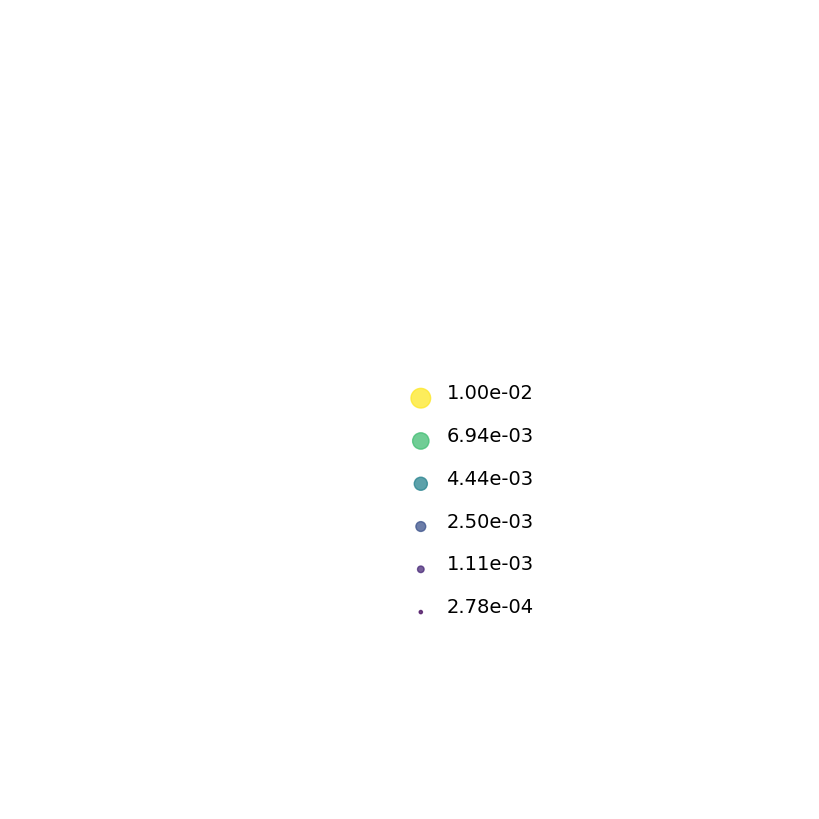

In [8]:
size = ((np.arange(6)+1)/6)**2*0.01

x = np.zeros(6)
y = np.arange(6)/2
z = np.zeros(6)

fig = plt.figure(figsize=(2,3))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=90, azim=-90)
ax.set_box_aspect([1,6,1])
ax.scatter(x, y, z, 
           s=size*2e4, c=size, vmin=0, vmax=0.01, 
           marker='o',alpha=0.75)
for i,s in enumerate(size):
    ax.text(x[i]+0.4, y[i], z[i], 
           '{:0.2e}'.format(s),fontsize=14)

# ax.set_xlabel(r'$\eta$',fontsize=18)
# ax.set_ylabel(r'$1/\kappa D$',fontsize=18)
# ax.set_zlabel(r'$AD$',fontsize=18)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_ylim([-2,7])
ax.set_xlim([-1,1])
ax.set_zlim([-1,1])
ax.axis('off')
plt.tight_layout(pad=0)
plt.gca().set_position([-1.75, -1.2, 4, 4])
plt.show()